In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as optimize

In [15]:
import numpy as np

def nll(theta,t):
    f,tau1,tau2 = theta
    return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  

class tcdecay_distribution:
    
    # constructors
    def __init__(self, f, tau1, tau2):
        self.f = float(f)
        self.tau1 = float(tau1)
        self.tau2 = float(tau2)
        
    # method to return exponential distribution    
    def evaluate_md(self,t):
        return self.f*(1/self.tau1)*np.exp(-t/self.tau1)+(1-self.f)*(1/self.tau2)*np.exp(-t/self.tau2)
    
    # method to return maximum value of distribution  
    def maximum(self):
        return 10.0
    
    # method to return random number with distribution
    # choose numpy random exponential or custom code 'calum'    
    def random_val(self):           
        x1 = 0.
        x2 = 0.
        x3 = 1.
        while ( x3 > x2 ):
            x1 = np.random.uniform()
            x1 = x1*7.
            x2 = self.evaluate_md(x1)
            x3 = np.random.uniform() * self.maximum()
        
        return x1
    
    # integrates area under the curve, in this example should be normalised
    # therefore always roughly equal to 1
    def numeric_integral(self,lo,hi,npoints=100000):
        
        sumf = 0
        
        for i in range(0,npoints):
            x = lo+np.random.uniform()*(hi-lo)
            sumf += self.evaluate_md(x)
            
        return sumf*(hi-lo)/npoints
    
    def nll(self,theta,t):
        f,tau1,tau2 = theta
        return -np.sum(np.log(f*(1/tau1)*np.exp(-t/tau1)+(1-f)*(1/tau2)*np.exp(-t/tau2)))  
    
    # performs an observation by taking n_muons random values
    # of the distribution
    def observation(self,n_muons=10000,method='TNC'):
        results = []
        for i in range(0,n_muons):
            results.append(self.random_val())
        
        mle_estimates = optimize.minimize(self.nll, [self.f, self.tau1, self.tau2], args=(np.array(results)),method=method)
        params = mle_estimates['x']
        # return (parameters_estimates, results)
        return params, np.array(results)

In [16]:
test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)

In [17]:
test.numeric_integral(0,10)

1.005164420129449

In [18]:
val, result = test.observation()  
val,result.shape

(array([ 0.76655737,  0.20395591,  1.24015665]), (10000,))

In [19]:
val, result = test.observation(method='Nelder-mead')  
val,result.shape

(array([ 0.75784732,  0.19923958,  1.2472156 ]), (10000,))

In [11]:
data = np.loadtxt('DecayTimesData.txt')
data.shape

(10000,)

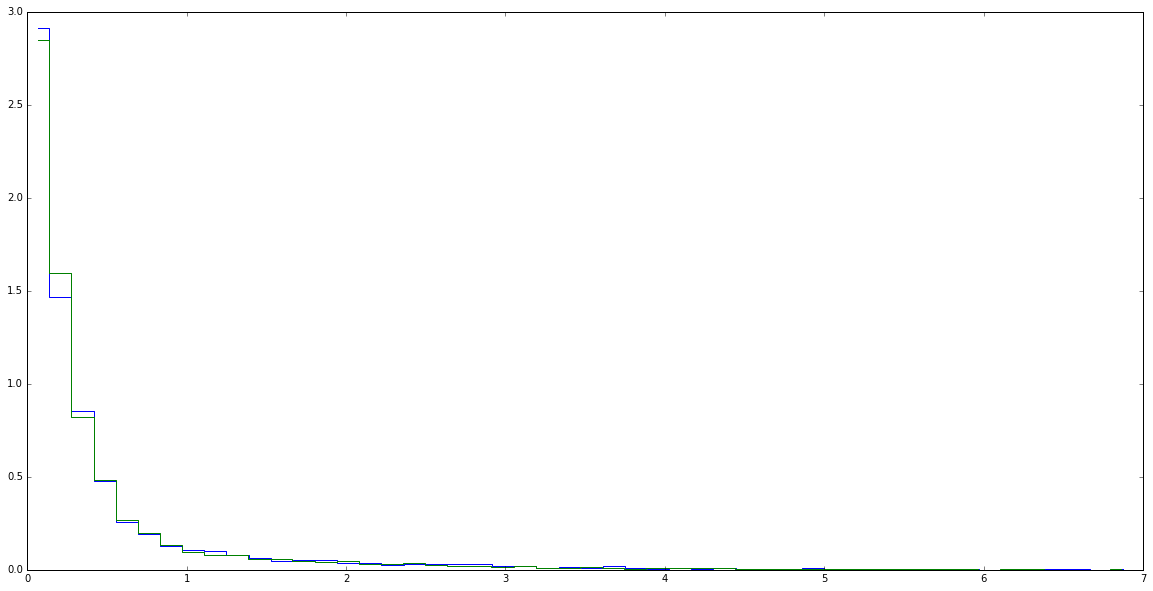

In [12]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

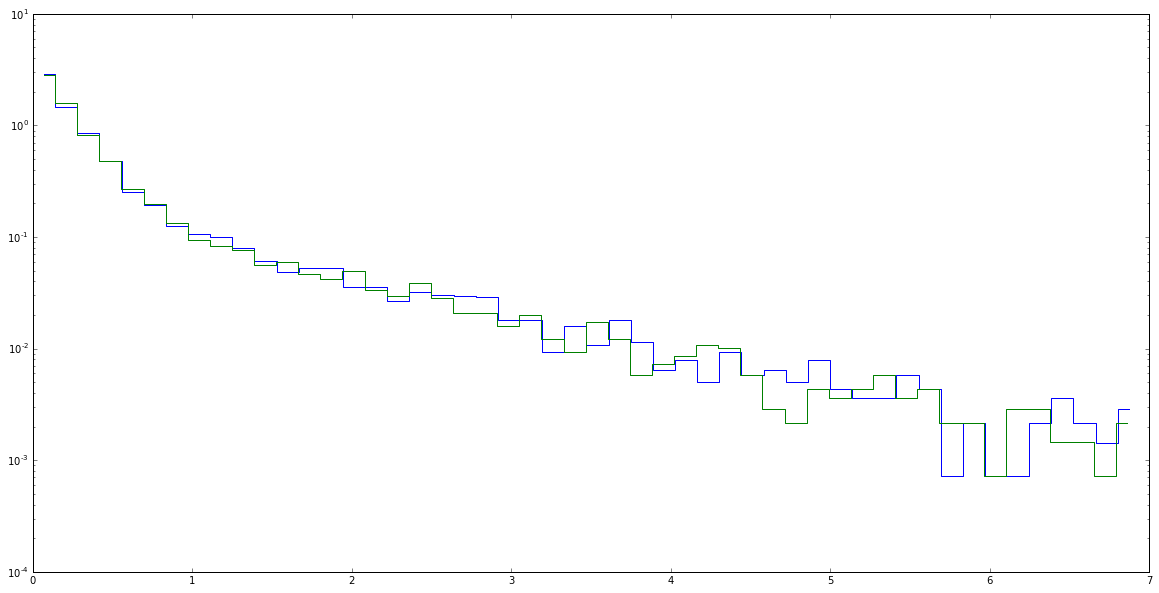

In [14]:
f,bins = np.histogram(data,bins=50,normed=True)
step = bins[1]-bins[0]
plt.figure(figsize=(20,10))
plt.plot(bins[1:]-step/2,f,drawstyle='steps-mid')
step

n, bins = np.histogram(result, bins=50, normed=True)

step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n,drawstyle='steps-mid')

plt.yscale('log')

In [21]:
test = tcdecay_distribution(0.74849409,  0.1978367 ,  1.30720393)
results = []
for _ in range(50):
    results.append(test.observation(method='Nelder-mead')[0])

In [24]:
results = np.load('/home/calum/Documents/NumRep/max_likelihood/run_sim_tnc.npy')

In [25]:
np.array(results).shape

(50, 3)

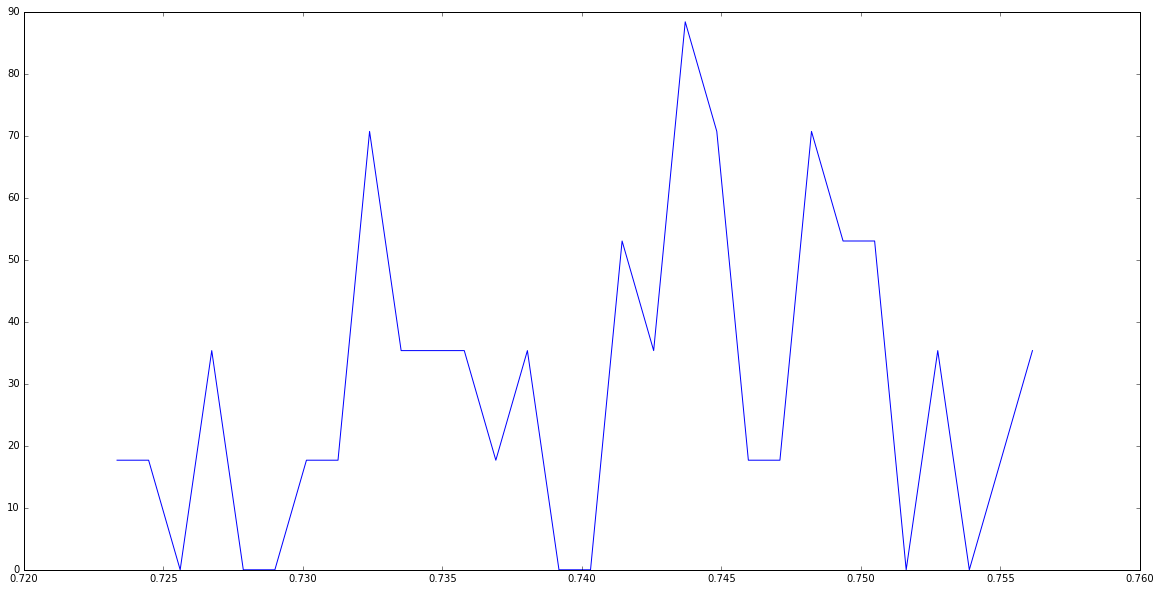

In [26]:
n, bins = np.histogram(np.array([row[0] for row in results if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

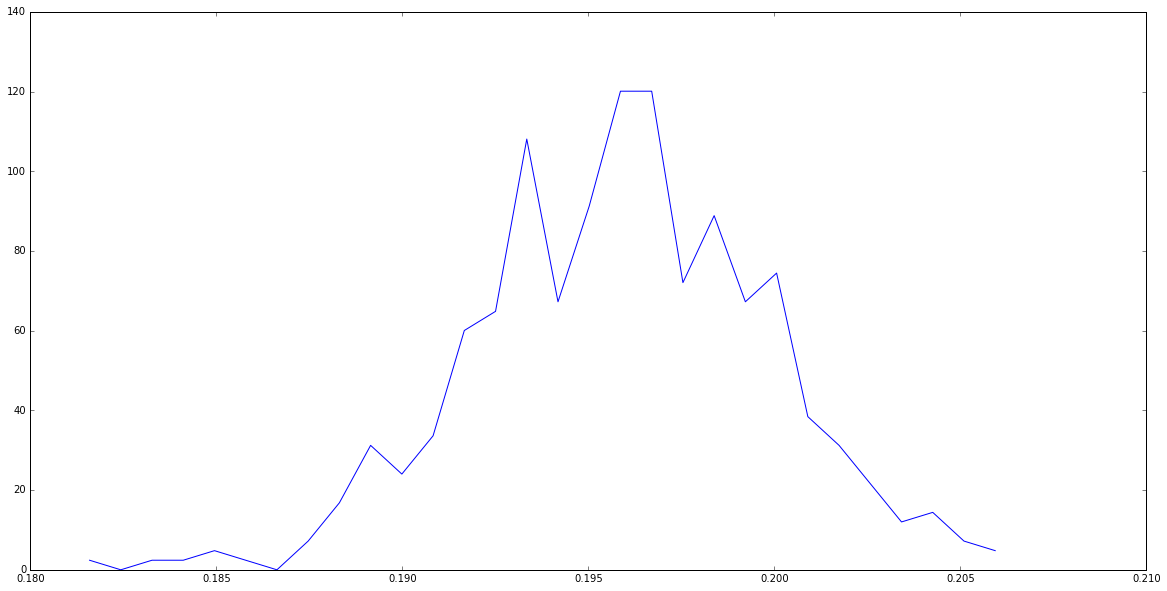

In [17]:
n, bins = np.histogram(np.array([row[1] for row in results if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

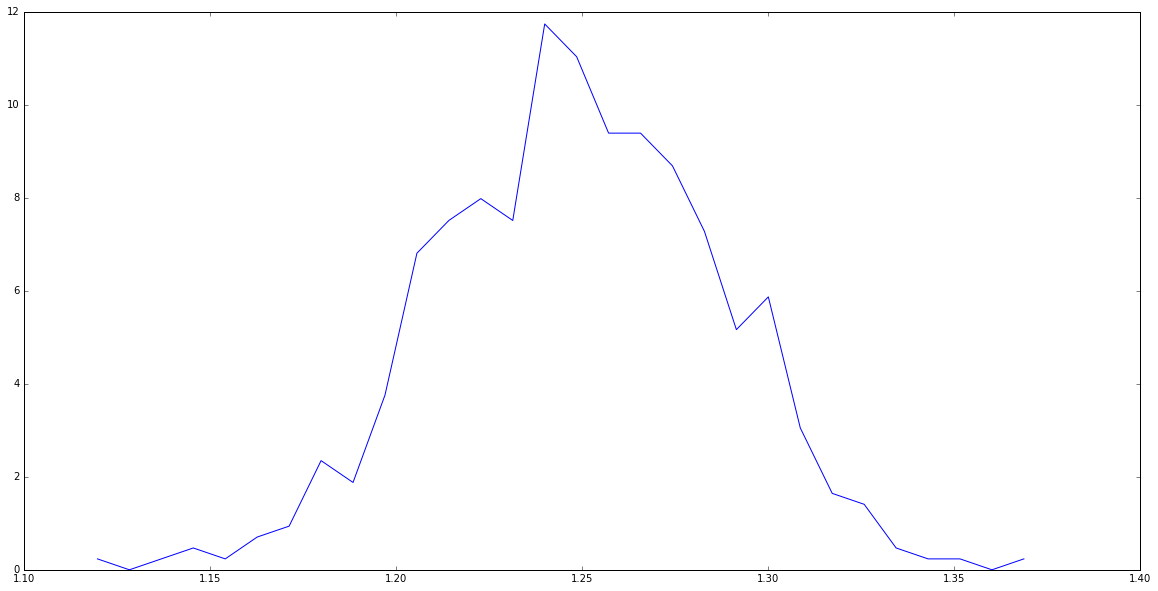

In [18]:
n, bins = np.histogram(np.array([row[2] for row in results if 10 >row[0] > 0]), bins=30, normed=True)

plt.figure(figsize=(20,10))
step = (bins[1]-bins[0])/2
plt.plot(bins[1:]-step,n)

In [107]:
len([row for row in results if row[0] < 0])

2

In [ ]:
test.num